# **Airbus Stock Analysis and Forecasting**

---



First we will start with importing the necessary libraries

In [43]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

Reading the data from the CSV and storing it as a dataframe. Also, converting the date column into a datetime format.

In [44]:
Data = pd.read_csv(r'C:\Users\Paritosh\Downloads\AIR.PA.csv', parse_dates = ['Date'])
df = pd.DataFrame(Data)
df['Date'] = pd.to_datetime(df['Date'])

Let's look at a brief summary of the dataframe.

In [45]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-09-17,13.00,13.08,10.56,12.22,8.126192,6345714.0
1,2001-09-18,12.00,12.01,10.86,11.05,7.348153,3341069.0
2,2001-09-19,11.10,11.47,10.20,11.14,7.408002,4203659.0
3,2001-09-20,11.40,11.60,9.70,10.21,6.789559,4100068.0
4,2001-09-21,9.82,10.80,9.14,9.65,6.417164,3182727.0


In [46]:
df.info()
print("\n")
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5470 entries, 0 to 5469
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5470 non-null   datetime64[ns]
 1   Open       5469 non-null   float64       
 2   High       5469 non-null   float64       
 3   Low        5469 non-null   float64       
 4   Close      5469 non-null   float64       
 5   Adj Close  5469 non-null   float64       
 6   Volume     5469 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 299.3 KB




,Open,High,Low,Close,Adj Close,Volume
count,5469.000000,5469.000000,5469.000000,5469.000000,5469.000000,5.469000e+03
mean,47.280869,47.894655,46.658186,47.285252,42.663492,2.407117e+06
std,35.547810,35.931463,35.166626,35.550970,35.751782,1.877375e+06
min,6.490000,7.050000,6.330000,6.500000,4.448979,0.000000e+00
25%,18.655001,18.945000,18.330000,18.674999,14.384488,1.419355e+06
50%,30.000000,30.379999,29.760000,30.080000,23.857052,1.985868e+06
75%,68.949997,70.010002,67.779999,69.050003,65.076645,2.862441e+06
max,138.479996,139.399994,137.139999,139.000000,132.692581,6.833590e+07


Removing all the outliers and null values.

In [47]:
df.isnull().sum()
df.isna().sum()
df.dropna(inplace = True)

Now we can plot the data and have a visualized look at it before we do some modifications.

<AxesSubplot:>

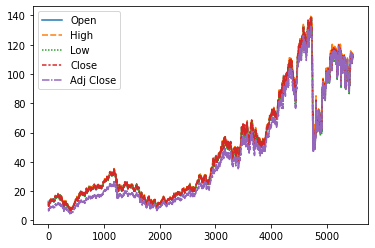

In [48]:
sns.lineplot(data = df[['Open','High','Low','Close','Adj Close']])

We can also summarise the data from a daily data to yearly to have a better understanding from a different perspective.

In [49]:
df1 = df
df1['Year'] = df1['Date'].dt.strftime('%Y')
cols = ['Date','Year','Open','High','Low','Close','Adj Close','Volume']
df1 = df1[cols]
df1.astype({'Year':'datetime64[ns]'})
dfy = df1.groupby(['Year']).mean()
dfy

,Open,High,Low,Close,Adj Close,Volume
Year,,,,,,
2001,12.885526,13.203947,12.456711,12.856053,8.549162,1.821236e+06
2002,14.107318,14.434330,13.781034,14.096590,9.533951,1.701342e+06
2003,12.274038,12.557538,12.049269,12.319269,8.664960,2.251996e+06
2004,20.665000,20.956336,20.403435,20.690954,14.887012,1.876381e+06
2005,26.086846,26.352000,25.867885,26.145077,19.497638,1.858644e+06
2006,26.275843,26.617372,25.883922,26.248039,20.031373,4.312240e+06
2007,23.095059,23.349216,22.780784,23.050275,17.805959,3.819922e+06
2008,14.392480,14.722910,14.007793,14.337754,11.212812,4.370699e+06
2009,12.505789,12.740559,12.267898,12.507613,9.957454,2.598176e+06


Now for the major part of this project we will use weekly data as it will be more feasible to work with. So, let's convert the daily data into weekly data.

In [50]:
def take_first(array_like):
    return array_like[0]
def take_last(array_like):
    return array_like[-1]
#df = df.set_index('Date')
logic = {'Open' : 'first',
         'High' : 'max',
         'Low'  : 'min',
         'Close': 'last',
         'Volume': 'sum'}
df.index = pd.to_datetime(df.index)
dfw = df.resample('W',on = 'Date').apply(logic)
dfw.index = dfw.index - pd.tseries.frequencies.to_offset("6D")
dfw = dfw[['Open', 'High', 'Low', 'Close', 'Volume']]
dfw

,Open,High,Low,Close,Volume
Date,,,,,
2001-09-17,13.000000,13.080000,9.140000,9.650000,21173237.0
2001-09-24,10.350000,12.090000,10.050000,11.540000,10997623.0
2001-10-01,12.150000,12.150000,9.900000,11.300000,11719518.0
2001-10-08,11.100000,13.050000,10.360000,12.610000,14632109.0
2001-10-15,12.520000,12.800000,11.750000,12.080000,8122696.0
...,...,...,...,...,...
2022-11-28,110.400002,112.300003,107.220001,110.980003,8101228.0
2022-12-05,111.120003,111.940002,107.040001,111.639999,6149425.0
2022-12-12,111.300003,114.300003,109.320000,109.980003,6602116.0


Since we have the weekly data, standard practice to analyse any stock data would be to calculate the Percentage Change of the price of the stock. To do so, we apply a lambda function to the dataframe to create a new column for Change(%) and calculate the percentage change for each week.

In [51]:
dfw['Change(%)'] = dfw['Close'].apply(lambda x: ((x - 9.65)/9.65) * 100)
dfw.head()

,Open,High,Low,Close,Volume,Change(%)
Date,,,,,,
2001-09-17,13.00,13.08,9.14,9.65,21173237.0,0.000000
2001-09-24,10.35,12.09,10.05,11.54,10997623.0,19.585492
2001-10-01,12.15,12.15,9.90,11.30,11719518.0,17.098446
2001-10-08,11.10,13.05,10.36,12.61,14632109.0,30.673575
2001-10-15,12.52,12.80,11.75,12.08,8122696.0,25.181347


Now the best way to look at the change would be visualising it. As can be seen from the plot below, the percentage change looks identical to the plot above for the OHLC Data. However, it would make more sense this way because the change is actually the summarised version of OHLC data so according to that, this is quite accurate.

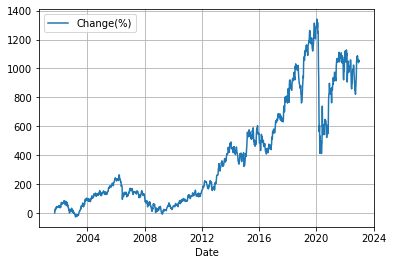

In [52]:
sns.lineplot(data = dfw[['Change(%)']])
plt.grid()

Another most commonly used visualisation technique is the Candle-Stick chart which provides an in-depth visualisation of the data. This is especially used to represent stock data. For this chart, we have sliced the data for the years after 2015 so that it can be easier to understand. The past data from the beginning would not really matter if someone wants to look at the recent data.

In [53]:
dfw_2 = dfw[pd.Timestamp('2015-01-05'):]
fig = go.Figure(data=[go.Candlestick(x=dfw_2.index,
                open=dfw_2['Open'],
                high=dfw_2['High'],
                low=dfw_2['Low'],
                close=dfw_2['Close'])])

fig.show()

Now, finally lets calculate moving averages for both the daily and weekly datasets and visualize them to look at a different perspective of the data.

Now lets plot the data from the year 2018 to the latest entry.

## Machine Learning

Now that we have analysed the data and calculated the OHLC data in the standard form. Let us get started with the Machine Learning part where it all gets much more interesting. First we store the average value of the OHLC data and normalise it for further use.

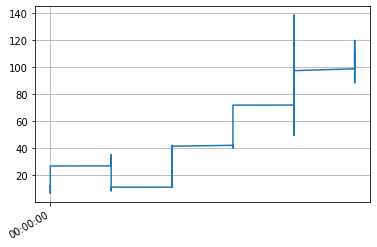

In [76]:
ohlc_avg = df[['Open','High','Low','Close']].mean(axis = 1).plot()
plt.grid()

In [78]:
ohlc_avg = df[['Open','High','Low','Close']].mean(axis = 1)
ohlc_avg = np.reshape(ohlc_avg.values, (len(ohlc_avg),1))
scaler = MinMaxScaler(feature_range=(0,1))
ohlc_avg = scaler.fit_transform(ohlc_avg)

In [56]:
train_ohlc = int(len(ohlc_avg) * 0.75)
test_ohlc = len(ohlc_avg) - train_ohlc
train_ohlc, test_ohlc = ohlc_avg[:train_ohlc,:], ohlc_avg[train_ohlc:len(ohlc_avg),:]

In [57]:
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - step_size - 1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [58]:
train_X, train_Y = new_dataset(train_ohlc, 1)
test_X, test_Y = new_dataset(test_ohlc, 1)

In [59]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [60]:
print(train_X.shape, test_X.shape)

(4099, 1, 1) (1366, 1, 1)


In [61]:
model = Sequential()
model.add(LSTM(32, input_shape = (1, 1), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))

In [62]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(train_X, train_Y, epochs = 5, batch_size = 1, verbose = 2)

train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

Epoch 1/5
 - 11s - loss: 0.0013
Epoch 2/5
 - 10s - loss: 3.4442e-05
Epoch 3/5
 - 10s - loss: 3.2220e-05
Epoch 4/5
 - 10s - loss: 3.2974e-05
Epoch 5/5
 - 10s - loss: 3.3487e-05


In [63]:
trainPredict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
testPredict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

In [64]:
testPredict.shape

(1366, 1)

In [65]:
trainScore = math.sqrt(mean_squared_error(train_Y[0], trainPredict[:,0]))
print("Train RMSE: ", round(trainScore,3))

testScore = math.sqrt(mean_squared_error(test_Y[0], testPredict[:,0]))
print("Test RMSE: ", round(testScore,3))

Train RMSE:  0.917
Test RMSE:  5.46


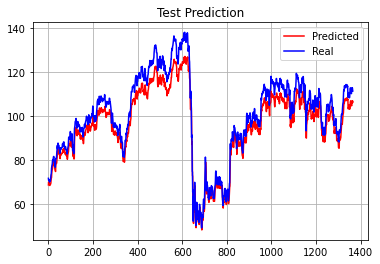

In [66]:
plt.plot(testPredict[:,0], color='Red',label = 'Predicted')
plt.plot(test_Y[0],color ='blue', label = 'Real')
plt.title('Test Prediction')
plt.grid()
plt.legend()

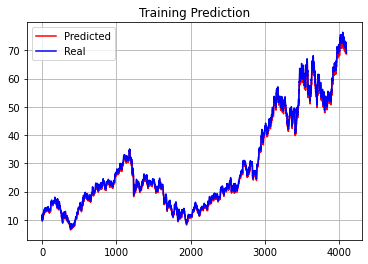

In [67]:
plt.plot(trainPredict[:,0], color = 'red', label = 'Predicted')
plt.plot(train_Y[0],color ='blue', label = 'Real')
plt.title('Training Prediction')
plt.grid()
plt.legend()

In [68]:
model2 = Sequential()
model2.add(LSTM(32, input_shape = (1, 1), return_sequences = True))
model2.add(LSTM(16))
model2.add(Dense(1))
model2.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [69]:
new_ohlc_avg = ohlc_avg.copy()

for i in range(10):
    trainX3, trainY3 = new_dataset(new_ohlc_avg, 1)
    trainX3 = np.reshape(trainX3, (trainX3.shape[0], 1, trainX3.shape[1]))
    model2.fit(trainX3, trainY3, epochs = 5, batch_size = 1, verbose = 2)
    
    last_val = new_ohlc_avg[-1]
    next_val = model2.predict(np.reshape(last_val,(1,1,1)))
    new_ohlc_avg = np.append(new_ohlc_avg, next_val[0])
    new_ohlc_avg = new_ohlc_avg.reshape(-1,1)
    
next_val = scaler.inverse_transform(new_ohlc_avg[-25:])
ohlc_avg = scaler.inverse_transform(ohlc_avg)

Epoch 1/5
 - 13s - loss: 0.0036
Epoch 2/5
 - 13s - loss: 1.3043e-04
Epoch 3/5
 - 13s - loss: 1.1918e-04
Epoch 4/5
 - 13s - loss: 1.2328e-04
Epoch 5/5
 - 14s - loss: 1.1583e-04
Epoch 1/5
 - 14s - loss: 1.1702e-04
Epoch 2/5
 - 14s - loss: 1.1664e-04
Epoch 3/5
 - 14s - loss: 1.1660e-04
Epoch 4/5
 - 14s - loss: 1.1428e-04
Epoch 5/5
 - 14s - loss: 1.1736e-04
Epoch 1/5
 - 13s - loss: 1.0585e-04
Epoch 2/5
 - 14s - loss: 1.0866e-04
Epoch 3/5
 - 14s - loss: 1.0940e-04
Epoch 4/5
 - 13s - loss: 1.0353e-04
Epoch 5/5
 - 14s - loss: 1.0986e-04
Epoch 1/5
 - 14s - loss: 9.9879e-05
Epoch 2/5
 - 14s - loss: 1.0513e-04
Epoch 3/5
 - 14s - loss: 1.0431e-04
Epoch 4/5
 - 14s - loss: 1.0097e-04
Epoch 5/5
 - 14s - loss: 1.0198e-04
Epoch 1/5
 - 13s - loss: 9.6068e-05
Epoch 2/5
 - 14s - loss: 9.3032e-05
Epoch 3/5
 - 13s - loss: 9.9884e-05
Epoch 4/5
 - 14s - loss: 9.5653e-05
Epoch 5/5
 - 13s - loss: 1.0090e-04
Epoch 1/5
 - 13s - loss: 9.6613e-05
Epoch 2/5
 - 13s - loss: 9.2020e-05
Epoch 3/5
 - 14s - loss: 9.3894e

In [70]:
next_val

array([[111.04499975],
       [112.21000075],
       [112.85000025],
       [112.95499975],
       [111.73999975],
       [110.3549995 ],
       [110.74999975],
       [110.329998  ],
       [112.13500225],
       [112.84499925],
       [111.635     ],
       [112.93500125],
       [112.295     ],
       [111.47999975],
       [111.31999975],
       [110.10352178],
       [111.76792883],
       [113.52847796],
       [112.08839201],
       [111.16831816],
       [111.37134662],
       [111.15711935],
       [111.32240569],
       [110.66263961],
       [110.95084645]])

In [71]:
ohlc_avg

array([[ 12.215     ],
       [ 11.48      ],
       [ 10.9775    ],
       ...,
       [112.295     ],
       [111.47999975],
       [111.31999975]])

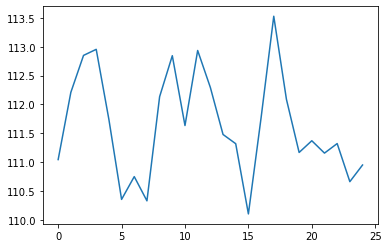

In [72]:
plt.plot(next_val)